# Getting Started

## Printing the best bid and the best ask

In [1]:
from numba import njit

import numpy as np

# numba.njit is strongly recommended for fast backtesting.
@njit
def print_bbo(hbt):
    # Iterating until hftbacktest reaches the end of data.
    # Elapses 60-sec every iteration.
    # Time unit is the same as data's timestamp's unit.
    # Timestamp of the sample data is in nanoseconds.
    while hbt.elapse(60 * 1e9) == 0:        
        # Gets the market depth for the first asset.
        depth = hbt.depth(0)

        # Prints the best bid and the best offer.
        print(
            'current_timestamp:', hbt.current_timestamp,
            ', best_bid:', np.round(depth.best_bid, 1),
            ', best_ask:', np.round(depth.best_ask, 1)
        )
    return True

In [2]:
from hftbacktest import BacktestAsset, HashMapMarketDepthMultiAssetMultiExchangeBacktest, close


asset = (
    BacktestAsset()
        # Sets the data to feed for this asset.
        #
        # Due to the vast size of tick-by-tick market depth and trade data,
        # loading the entire dataset into memory can be challenging,
        # particularly when backtesting across multiple days.
        # HftBacktest offers lazy loading support and is compatible with npy and preferably npz.
        #
        # For details on the normalized feed data, refer to the following documents.
        # * https://hftbacktest.readthedocs.io/en/latest/data.html    
        # * https://hftbacktest.readthedocs.io/en/latest/tutorials/Data%20Preparation.html
        .data(['usdm/btcusdt_20240719.npz'])
        # Sets the initial snapshot (optional).
        .initial_snapshot('usdm/btcusdt_20240718_eod.npz')
        # Asset type:
        # * Linear
        # * Inverse.
        # 1.0 represents the contract size, which is the value of the asset per quoted price.
        .linear_asset(1.0) 
        # HftBacktest provides two built-in latency models.
        # * constant_latency
        # * intp_order_latency
        # To implement your own latency model, please use Rust.
        # 
        # Time unit is the same as data's timestamp's unit. Timestamp of the sample data is in nanoseconds.
        # Sets the order entry latency and response latency to 100ms.
        .constant_latency(100_000_000, 100_000_000)
        # HftBacktest provides several types of built-in queue position models.
        # Please find the details in the documents below.
        # https://hftbacktest.readthedocs.io/en/latest/tutorials/Probability%20Queue%20Models.html
        #
        # To implement your own queue position model, please use Rust.
        .risk_adverse_queue_model() 
        # HftBacktest provides two built-in exchange models.
        # * no_partial_fill_exchange
        # * partial_fill_exchange
        # To implement your own exchange model, please use Rust.
        .no_partial_fill_exchange()
        # 0.02% maker fee. If the fee is negative, it represents a rebate.
        # For example, -0.00005 represents a 0.005% rebate for the maker order.
        .maker_fee(0.0002)
        # 0.07% taker fee. 
        .taker_fee(0.0007)
        # Tick size of this asset: minimum price increasement
        .tick_size(0.1)
        # Lot size of this asset: minimum trading unit.
        .lot_size(0.001)
        # Sets the capacity of the vector that stores trades occurring in the market.
        # If you set the size, you need call `clear_last_trades` to clear the vector.
        # A value of 0 indicates that no market trades are stored.
        .trade_len(0)
)

# HftBacktest provides several types of built-in market depth implementations.
# HashMapMarketDepthMultiAssetMultiExchangeBacktest constructs a MultiAssetMultiExchangeBacktest
# using a HashMap-based market depth implementation.
# Another useful implementation is ROIVectorMarketDepth, which is utilized in
# ROIVectorMarketDepthMultiAssetMultiExchangeBacktest.
# Please find the details in the document below.
hbt = HashMapMarketDepthMultiAssetMultiExchangeBacktest([asset])

You can see the best bid and best ask every 60 seconds. Since the price is a 32-bit float, there may be floating-point errors. Be careful when using it. In the example, for readability, the price is rounded based on the tick size.

In [3]:
print_bbo(hbt)

current_timestamp: 1721347261533000000 , best_bid: 63979.9 , best_ask: 63980.0
current_timestamp: 1721347321533000000 , best_bid: 63931.3 , best_ask: 63931.4
current_timestamp: 1721347381533000000 , best_bid: 63870.8 , best_ask: 63870.9
current_timestamp: 1721347441533000000 , best_bid: 63848.4 , best_ask: 63848.5
current_timestamp: 1721347501533000000 , best_bid: 63889.0 , best_ask: 63889.1


True

HftBacktest cannot be reused at this time. Therefore, after using the backtest, make sure to close it.

In [4]:
close(hbt)

## Feeding the data

When you possess adequate memory, preloading the data into memory and providing it as input will be more efficient than lazy-loading during repeated backtesting.

In [5]:
btcusdt_20230719 = np.load('usdm/btcusdt_20240719.npz')['data']
btcusdt_20230718_eod = np.load('usdm/btcusdt_20240718_eod.npz')['data']

asset = (
    BacktestAsset()
        .data([btcusdt_20230719])
        .initial_snapshot(btcusdt_20230718_eod)
        .linear_asset(1.0) 
        .constant_latency(100_000_000, 100_000_000)
        .risk_adverse_queue_model() 
        .no_partial_fill_exchange()
        .maker_fee(0.0002)
        .taker_fee(0.0007)
        .tick_size(0.1)
        .lot_size(0.001)
        .trade_len(0)
)
hbt = HashMapMarketDepthMultiAssetMultiExchangeBacktest([asset])

In [6]:
print_bbo(hbt)
close(hbt)

current_timestamp: 1721347261533000000 , best_bid: 63979.9 , best_ask: 63980.0
current_timestamp: 1721347321533000000 , best_bid: 63931.3 , best_ask: 63931.4
current_timestamp: 1721347381533000000 , best_bid: 63870.8 , best_ask: 63870.9
current_timestamp: 1721347441533000000 , best_bid: 63848.4 , best_ask: 63848.5
current_timestamp: 1721347501533000000 , best_bid: 63889.0 , best_ask: 63889.1


## Getting the market depth

In [7]:
@njit
def print_3depth(hbt):
    while hbt.elapse(60 * 1e9) == 0:
        print('current_timestamp:', hbt.current_timestamp)

        # Gets the market depth for the first asset, in the same order as when you created the backtest.
        depth = hbt.depth(0)

        # a key of bid_depth or ask_depth is price in ticks.
        # (integer) price_tick = price / tick_size
        i = 0
        for tick_price in range(depth.best_ask_tick, depth.best_ask_tick + 100):
            qty = depth.ask_qty_at_tick(tick_price)
            if qty > 0:
                print(
                    'ask: ',
                    qty,
                    '@',
                    np.round(tick_price * depth.tick_size, 1)
                )
                
                i += 1
                if i == 3:
                    break
        i = 0
        for tick_price in range(depth.best_bid_tick, max(depth.best_bid_tick - 100, 0), -1):
            qty = depth.bid_qty_at_tick(tick_price)
            if qty > 0:
                print(
                    'bid: ',
                    qty,
                    '@',
                    np.round(tick_price * depth.tick_size, 1)
                )
            
                i += 1
                if i == 3:
                    break
    return True

In [8]:
asset = (
    BacktestAsset()
        .data(['usdm/btcusdt_20240719.npz'])
        .initial_snapshot('usdm/btcusdt_20240718_eod.npz')
        .linear_asset(1.0) 
        .constant_latency(100_000_000, 100_000_000)
        .risk_adverse_queue_model() 
        .no_partial_fill_exchange()
        .maker_fee(0.0002)
        .taker_fee(0.0007)
        .tick_size(0.1)
        .lot_size(0.001)
        .trade_len(0)
)
hbt = HashMapMarketDepthMultiAssetMultiExchangeBacktest([asset])

In [9]:
print_3depth(hbt)
close(hbt)

current_timestamp: 1721347261533000000
ask:  1.661 @ 63980.0
ask:  0.166 @ 63980.1
ask:  0.002 @ 63981.4
bid:  17.429 @ 63979.9
bid:  0.011 @ 63979.8
bid:  0.347 @ 63979.7
current_timestamp: 1721347321533000000
ask:  40.245 @ 63931.4
ask:  1.133 @ 63931.5
ask:  0.1 @ 63931.6
bid:  2.656 @ 63931.3
bid:  0.166 @ 63930.7
bid:  0.003 @ 63930.6
current_timestamp: 1721347381533000000
ask:  1.147 @ 63870.9
ask:  0.002 @ 63871.2
ask:  0.166 @ 63871.6
bid:  10.989 @ 63870.8
bid:  0.278 @ 63870.7
bid:  0.007 @ 63870.6
current_timestamp: 1721347441533000000
ask:  15.426 @ 63848.5
ask:  0.009 @ 63848.6
ask:  0.002 @ 63849.0
bid:  11.01 @ 63848.4
bid:  0.004 @ 63848.3
bid:  1.083 @ 63848.0
current_timestamp: 1721347501533000000
ask:  9.029 @ 63889.1
ask:  0.013 @ 63889.2
ask:  0.005 @ 63889.3
bid:  5.758 @ 63889.0
bid:  0.097 @ 63888.9
bid:  0.114 @ 63888.0


## Submitting an order

In [10]:
from hftbacktest import LIMIT, GTC, NONE, NEW, FILLED, CANCELED, EXPIRED

@njit
def print_orders(hbt):
    # You can access open orders and also closed orders via hbt.orders.
    # Gets the OrderDict for the first asset.
    orders = hbt.orders(0)
    
    # hbt.orders is a dictionary, but be aware that it does not support all dict methods, and its keys are order_id (int).
    order_values = orders.values()
    while True:
        order = order_values.next()
        if order is None:
            break
    
        order_status = ''
        if order.status == NONE:
            order_status = 'NONE' # Exchange hasn't received an order yet.
        elif order.status == NEW:
            order_status = 'NEW'
        elif order.status == FILLED:
            order_status = 'FILLED'
        elif order.status == CANCELED:
            order_status = 'CANCELED'
        elif order.status == EXPIRED:
            order_status = 'EXPIRED' 
            
        order_req = ''
        if order.req == NONE:
            order_req = 'NONE'
        elif order.req == NEW:
            order_req = 'NEW'
        elif order.req == CANCELED:
            order_req = 'CANCEL'
            
        print(
            'current_timestamp:', hbt.current_timestamp, 
             ', order_id:', order.order_id,
             ', order_price:', np.round(order.price, 1),
             ', order_qty:', order.qty,
             ', order_status:', order_status,
             ', order_req:', order_req
        )

@njit
def submit_order(hbt):
    is_order_submitted = False
    while hbt.elapse(30 * 1e9) == 0:
        # Prints open orders.
        print_orders(hbt)

        depth = hbt.depth(0)
        
        if not is_order_submitted:
            # Submits a buy order at 300 ticks below the best bid for the first asset.
            order_id = 1
            order_price = depth.best_bid - 300 * depth.tick_size
            order_qty = 1
            time_in_force = GTC # Good 'till cancel
            order_type = LIMIT
            hbt.submit_buy_order(0, order_id, order_price, order_qty, time_in_force, order_type, False)
            is_order_submitted = True
    return True

In [11]:
asset = (
    BacktestAsset()
        .data(['usdm/btcusdt_20240719.npz'])
        .initial_snapshot('usdm/btcusdt_20240718_eod.npz')
        .linear_asset(1.0) 
        .constant_latency(100_000_000, 100_000_000)
        .risk_adverse_queue_model() 
        .no_partial_fill_exchange()
        .maker_fee(0.0002)
        .taker_fee(0.0007)
        .tick_size(0.1)
        .lot_size(0.001)
        .trade_len(0)
)
hbt = HashMapMarketDepthMultiAssetMultiExchangeBacktest([asset])

In [12]:
submit_order(hbt)
close(hbt)

current_timestamp: 1721347261533000000 , order_id: 1 , order_price: 63885.7 , order_qty: 1.0 , order_status: NEW , order_req: NONE
current_timestamp: 1721347291533000000 , order_id: 1 , order_price: 63885.7 , order_qty: 1.0 , order_status: NEW , order_req: NONE
current_timestamp: 1721347321533000000 , order_id: 1 , order_price: 63885.7 , order_qty: 1.0 , order_status: NEW , order_req: NONE
current_timestamp: 1721347351533000000 , order_id: 1 , order_price: 63885.7 , order_qty: 1.0 , order_status: NEW , order_req: NONE
current_timestamp: 1721347381533000000 , order_id: 1 , order_price: 63885.7 , order_qty: 1.0 , order_status: FILLED , order_req: NONE
current_timestamp: 1721347411533000000 , order_id: 1 , order_price: 63885.7 , order_qty: 1.0 , order_status: FILLED , order_req: NONE
current_timestamp: 1721347441533000000 , order_id: 1 , order_price: 63885.7 , order_qty: 1.0 , order_status: FILLED , order_req: NONE
current_timestamp: 1721347471533000000 , order_id: 1 , order_price: 63885.

## Clearing inactive orders (FILLED, CANCELED, EXPIRED)

In [13]:
from hftbacktest import GTC

@njit
def clear_inactive_orders(hbt):
    is_order_submitted = False
    while hbt.elapse(30 * 1e9) == 0:
        print_orders(hbt)
        
        # Removes inactive(FILLED, CANCELED, EXPIRED) orders from hbt.orders for the first asset.
        hbt.clear_inactive_orders(0)

        depth = hbt.depth(0)
        
        if not is_order_submitted:
            order_id = 1
            order_price = depth.best_bid - 300 * depth.tick_size
            order_qty = 1
            time_in_force = GTC
            order_type = LIMIT
            hbt.submit_buy_order(0, order_id, order_price, order_qty, time_in_force, order_type, False)
            is_order_submitted = True
    return True

In [14]:
asset = (
    BacktestAsset()
        .data(['usdm/btcusdt_20240719.npz'])
        .initial_snapshot('usdm/btcusdt_20240718_eod.npz')
        .linear_asset(1.0) 
        .constant_latency(100_000_000, 100_000_000)
        .risk_adverse_queue_model() 
        .no_partial_fill_exchange()
        .maker_fee(0.0002)
        .taker_fee(0.0007)
        .tick_size(0.1)
        .lot_size(0.001)
        .trade_len(0)
)
hbt = HashMapMarketDepthMultiAssetMultiExchangeBacktest([asset])

In [25]:
clear_inactive_orders(hbt)
close(hbt)

True

## Watching a order status - pending due to order latency

In [16]:
from hftbacktest import GTC

@njit
def watch_pending(hbt):
    is_order_submitted = False
    # Elapses 0.01-sec every iteration.
    while hbt.elapse(0.01 * 1e9) == 0:
        print_orders(hbt)
        
        hbt.clear_inactive_orders(0)

        depth = hbt.depth(0)
        
        if not is_order_submitted:
            order_id = 1
            order_price = depth.best_bid - 300 * depth.tick_size
            order_qty = 1
            time_in_force = GTC
            order_type = LIMIT
            hbt.submit_buy_order(0, order_id, order_price, order_qty, time_in_force, order_type, False)
            is_order_submitted = True
            
        # Prevents too many prints
        orders = hbt.orders(0)
        order = orders.get(order_id)
        if order.status == NEW:
            return False
    return True

In [17]:
asset = (
    BacktestAsset()
        .data(['usdm/btcusdt_20240719.npz'])
        .initial_snapshot('usdm/btcusdt_20240718_eod.npz')
        .linear_asset(1.0) 
        .constant_latency(100_000_000, 100_000_000)
        .risk_adverse_queue_model() 
        .no_partial_fill_exchange()
        .maker_fee(0.0002)
        .taker_fee(0.0007)
        .tick_size(0.1)
        .lot_size(0.001)
        .trade_len(0)
)
hbt = HashMapMarketDepthMultiAssetMultiExchangeBacktest([asset])

The `order_status` is `None` until the acceptance message is received.

In [18]:
watch_pending(hbt)
close(hbt)

current_timestamp: 1721347201553000000 , order_id: 1 , order_price: 63929.9 , order_qty: 1.0 , order_status: NONE , order_req: NEW
current_timestamp: 1721347201563000000 , order_id: 1 , order_price: 63929.9 , order_qty: 1.0 , order_status: NONE , order_req: NEW
current_timestamp: 1721347201573000000 , order_id: 1 , order_price: 63929.9 , order_qty: 1.0 , order_status: NONE , order_req: NEW
current_timestamp: 1721347201583000000 , order_id: 1 , order_price: 63929.9 , order_qty: 1.0 , order_status: NONE , order_req: NEW
current_timestamp: 1721347201593000000 , order_id: 1 , order_price: 63929.9 , order_qty: 1.0 , order_status: NONE , order_req: NEW
current_timestamp: 1721347201603000000 , order_id: 1 , order_price: 63929.9 , order_qty: 1.0 , order_status: NONE , order_req: NEW
current_timestamp: 1721347201613000000 , order_id: 1 , order_price: 63929.9 , order_qty: 1.0 , order_status: NONE , order_req: NEW
current_timestamp: 1721347201623000000 , order_id: 1 , order_price: 63929.9 , order

## Waiting for an order response

In [19]:
from hftbacktest import GTC

@njit
def wait_for_order_response(hbt):
    order_id = 0
    is_order_submitted = False
    while hbt.elapse(0.01 * 1e9) == 0:
        print_orders(hbt)
        
        hbt.clear_inactive_orders(0)
        
        # Prevents too many prints
        orders = hbt.orders(0)
        if order_id in orders:
            if orders.get(order_id).status == NEW:
                return False

        depth = hbt.depth(0)
        
        if not is_order_submitted:
            order_id = 1
            order_price = depth.best_bid
            order_qty = 1
            time_in_force = GTC
            order_type = LIMIT
            hbt.submit_buy_order(0, order_id, order_price, order_qty, time_in_force, order_type, False)
            # Waits for the order response for a given order id for the first asset.
            print('an order is submitted at', hbt.current_timestamp)

            # Timeout is set 1-second.
            hbt.wait_order_response(0, order_id, 1 * 1e9)
            print('an order response is received at', hbt.current_timestamp)
            is_order_submitted = True
    return True

In [20]:
asset = (
    BacktestAsset()
        .data(['usdm/btcusdt_20240719.npz'])
        .initial_snapshot('usdm/btcusdt_20240718_eod.npz')
        .linear_asset(1.0) 
        .constant_latency(100_000_000, 100_000_000)
        .risk_adverse_queue_model() 
        .no_partial_fill_exchange()
        .maker_fee(0.0002)
        .taker_fee(0.0007)
        .tick_size(0.1)
        .lot_size(0.001)
        .trade_len(0)
)
hbt = HashMapMarketDepthMultiAssetMultiExchangeBacktest([asset])

Since the `ConstantLatency` model is used, the round-trip latency is exactly 200ms. Ideally, using historical order latency data collected from the live market is the best approach. However, if this data is not available, starting with artificially generated order latency based on feed latency is another option. We will explore this in the following examples.

In [21]:
wait_for_order_response(hbt)
close(hbt)

an order is submitted at 1721347201543000000
an order response is received at 1721347201743000000
current_timestamp: 1721347201753000000 , order_id: 1 , order_price: 63959.9 , order_qty: 1.0 , order_status: NEW , order_req: NONE


## Printing position, balance, fee, and equity

In [22]:
@njit
def position(hbt):
    is_order_submitted = False
    while hbt.elapse(60 * 1e9) == 0:
        print_orders(hbt)
        
        hbt.clear_inactive_orders(0)
        
        # Prints position
        print(
            'current_timestamp:', hbt.current_timestamp,
            ', position:', hbt.position(0),
            ', balance:', hbt.state_values(0).balance,
            ', fee:', hbt.state_values(0).fee
        )

        depth = hbt.depth(0)
        
        if not is_order_submitted:
            order_id = 1
            order_price = depth.best_bid
            order_qty = 1
            time_in_force = GTC
            order_type = LIMIT
            hbt.submit_buy_order(0, order_id, order_price, order_qty, time_in_force, order_type, False)
            
            # Timeout is set 1-second.
            hbt.wait_order_response(0, order_id, 1e9)
            is_order_submitted = True
    return True

In [23]:
asset = (
    BacktestAsset()
        .data(['usdm/btcusdt_20240719.npz'])
        .initial_snapshot('usdm/btcusdt_20240718_eod.npz')
        .linear_asset(1.0) 
        .constant_latency(100_000_000, 100_000_000)
        .risk_adverse_queue_model() 
        .no_partial_fill_exchange()
        .maker_fee(0.0002)
        .taker_fee(0.0007)
        .tick_size(0.1)
        .lot_size(0.001)
        .trade_len(0)
)
hbt = HashMapMarketDepthMultiAssetMultiExchangeBacktest([asset])

In [24]:
position(hbt)
close(hbt)

current_timestamp: 1721347261533000000 , position: 0.0 , balance: 0.0 , fee: 0.0
current_timestamp: 1721347321733000000 , order_id: 1 , order_price: 63979.9 , order_qty: 1.0 , order_status: FILLED , order_req: NONE
current_timestamp: 1721347321733000000 , position: 1.0 , balance: -63979.9 , fee: 12.79598
current_timestamp: 1721347381733000000 , position: 1.0 , balance: -63979.9 , fee: 12.79598
current_timestamp: 1721347441733000000 , position: 1.0 , balance: -63979.9 , fee: 12.79598
current_timestamp: 1721347501733000000 , position: 1.0 , balance: -63979.9 , fee: 12.79598


## Canceling an open order

In [25]:
@njit
def submit_and_cancel_order(hbt):
    is_order_submitted = False
    while hbt.elapse(0.1 * 1e9) == 0:
        print_orders(hbt)
        
        hbt.clear_inactive_orders(0)
        
        # Cancels if there is an open order
        orders = hbt.orders(0)
        order_values = orders.values()
        while True:
            order = order_values.next()
            if order is None:
                break
            
            # an order is only cancellable if order status is NEW.
            # cancel request is negated if the order is already filled or filled before cancel request is processed.
            if order.cancellable:
                hbt.cancel(0, order.order_id, False)
                # You can see status still NEW and see req CANCEL.
                print_orders(hbt)
                # cancels request also has order entry/response latencies the same as submitting.
                hbt.wait_order_response(0, order.order_id, 1e9)
       
        if not is_order_submitted:
            depth = hbt.depth(0)
            
            order_id = 1
            order_price = depth.best_bid - 100 * depth.tick_size
            order_qty = 1
            time_in_force = GTC
            order_type = LIMIT
            hbt.submit_buy_order(0, order_id, order_price, order_qty, time_in_force, order_type, False)
            
            # Timeout is set 1-second.
            hbt.wait_order_response(0, order_id, 1e9)
            is_order_submitted = True
        else:
            if len(hbt.orders(0)) == 0:
                return False
    return True

In [26]:
asset = (
    BacktestAsset()
        .data(['usdm/btcusdt_20240719.npz'])
        .initial_snapshot('usdm/btcusdt_20240718_eod.npz')
        .linear_asset(1.0) 
        .constant_latency(100_000_000, 100_000_000)
        .risk_adverse_queue_model() 
        .no_partial_fill_exchange()
        .maker_fee(0.0002)
        .taker_fee(0.0007)
        .tick_size(0.1)
        .lot_size(0.001)
        .trade_len(0)
)
hbt = HashMapMarketDepthMultiAssetMultiExchangeBacktest([asset])

In [27]:
submit_and_cancel_order(hbt)
close(hbt)

current_timestamp: 1721347201933000000 , order_id: 1 , order_price: 63949.9 , order_qty: 1.0 , order_status: NEW , order_req: NONE
current_timestamp: 1721347201933000000 , order_id: 1 , order_price: 63949.9 , order_qty: 1.0 , order_status: NEW , order_req: CANCEL
current_timestamp: 1721347202233000000 , order_id: 1 , order_price: 63949.9 , order_qty: 1.0 , order_status: CANCELED , order_req: NONE


## Market order

In [28]:
from hftbacktest import MARKET

@njit
def print_orders_exec_price(hbt):
    orders = hbt.orders(0)
    order_values = orders.values()
    while True:
        order = order_values.next()
        if order is None:
            break
            
        order_status = ''
        if order.status == NONE:
            order_status = 'NONE'
        elif order.status == NEW:
            order_status = 'NEW'
        elif order.status == FILLED:
            order_status = 'FILLED'
        elif order.status == CANCELED:
            order_status = 'CANCELED'
        elif order.status == EXPIRED:
            order_status = 'EXPIRED' 
            
        order_req = ''
        if order.req == NONE:
            order_req = 'NONE'
        elif order.req == NEW:
            order_req = 'NEW'
        elif order.req == CANCELED:
            order_req = 'CANCEL'
            
        print(
            'current_timestamp:', hbt.current_timestamp, 
             ', order_id:', order.order_id,
             ', order_price:', np.round(order.price, 1),
             ', order_qty:', order.qty,
             ', order_status:', order_status,
             ', exec_price:', np.round(order.exec_price, 1)
        )
        
@njit
def market_order(hbt):
    is_order_submitted = False
    while hbt.elapse(60 * 1e9) == 0:
        print_orders(hbt)
        
        hbt.clear_inactive_orders(0)

        state_values = hbt.state_values(0)
        
        print(
            'current_timestamp:', hbt.current_timestamp,
             ', position:', hbt.position(0),
             ', balance:', state_values.balance,
             ', fee:', state_values.fee
        )
        
        if not is_order_submitted:
            depth = hbt.depth(0)
            
            order_id = 1
            # Sets an arbitrary price, which does not affect MARKET orders.
            order_price = depth.best_bid
            order_qty = 1
            time_in_force = GTC
            order_type = MARKET
            hbt.submit_sell_order(0, order_id, order_price, order_qty, time_in_force, order_type, False)
            hbt.wait_order_response(0, order_id, 1e9)
            # You can see the order immediately filled.
            # Also you can see the order executed at the best bid which is different from what it was submitted at.
            print('best_bid:', depth.best_bid)
            print_orders_exec_price(hbt)            
            is_order_submitted = True
    return True

In [29]:
asset = (
    BacktestAsset()
        .data(['usdm/btcusdt_20240719.npz'])
        .initial_snapshot('usdm/btcusdt_20240718_eod.npz')
        .linear_asset(1.0) 
        .constant_latency(100_000_000, 100_000_000)
        .risk_adverse_queue_model() 
        .no_partial_fill_exchange()
        .maker_fee(0.0002)
        .taker_fee(0.0007)
        .tick_size(0.1)
        .lot_size(0.001)
        .trade_len(0)
)
hbt = HashMapMarketDepthMultiAssetMultiExchangeBacktest([asset])

In [30]:
market_order(hbt)
close(hbt)

current_timestamp: 1721347261533000000 , position: 0.0 , balance: 0.0 , fee: 0.0
best_bid: 63981.9
current_timestamp: 1721347261733000000 , order_id: 1 , order_price: 63979.9 , order_qty: 1.0 , order_status: FILLED , exec_price: 63981.9
current_timestamp: 1721347321733000000 , order_id: 1 , order_price: 63979.9 , order_qty: 1.0 , order_status: FILLED , order_req: NONE
current_timestamp: 1721347321733000000 , position: -1.0 , balance: 63981.9 , fee: 44.78733
current_timestamp: 1721347381733000000 , position: -1.0 , balance: 63981.9 , fee: 44.78733
current_timestamp: 1721347441733000000 , position: -1.0 , balance: 63981.9 , fee: 44.78733
current_timestamp: 1721347501733000000 , position: -1.0 , balance: 63981.9 , fee: 44.78733


## GTX, Post-Only order

In [31]:
from hftbacktest import GTX

@njit
def submit_gtx(hbt):
    is_order_submitted = False
    while hbt.elapse(60 * 1e9) == 0:
        print_orders(hbt)
        
        hbt.clear_inactive_orders(0)
        
        state_values = hbt.state_values(0)
        
        print(
            'current_timestamp:', hbt.current_timestamp,
             ', position:', hbt.position(0),
             ', balance:', state_values.balance,
             ', fee:', state_values.fee
        )
        
        if not is_order_submitted:
            depth = hbt.depth(0)
            
            order_id = 1
            # Sets a deep price in the opposite side and it will be rejected by GTX.
            order_price = depth.best_bid - 100 * depth.tick_size
            order_qty = 1
            time_in_force = GTX
            order_type = LIMIT
            hbt.submit_sell_order(0, order_id, order_price, order_qty, time_in_force, order_type, False)
            hbt.wait_order_response(0, order_id, 1e9)
            is_order_submitted = True
    return True

In [32]:
asset = (
    BacktestAsset()
        .data(['usdm/btcusdt_20240719.npz'])
        .initial_snapshot('usdm/btcusdt_20240718_eod.npz')
        .linear_asset(1.0) 
        .constant_latency(100_000_000, 100_000_000)
        .risk_adverse_queue_model() 
        .no_partial_fill_exchange()
        .maker_fee(0.0002)
        .taker_fee(0.0007)
        .tick_size(0.1)
        .lot_size(0.001)
        .trade_len(0)
)
hbt = HashMapMarketDepthMultiAssetMultiExchangeBacktest([asset])

In [33]:
submit_gtx(hbt)
close(hbt)

current_timestamp: 1721347261533000000 , position: 0.0 , balance: 0.0 , fee: 0.0
current_timestamp: 1721347321733000000 , order_id: 1 , order_price: 63969.9 , order_qty: 1.0 , order_status: EXPIRED , order_req: NONE
current_timestamp: 1721347321733000000 , position: 0.0 , balance: 0.0 , fee: 0.0
current_timestamp: 1721347381733000000 , position: 0.0 , balance: 0.0 , fee: 0.0
current_timestamp: 1721347441733000000 , position: 0.0 , balance: 0.0 , fee: 0.0
current_timestamp: 1721347501733000000 , position: 0.0 , balance: 0.0 , fee: 0.0


## Plotting BBO

In [34]:
@njit
def plot_bbo(hbt, local_timestamp, best_bid, best_ask):
    while hbt.elapse(1 * 1e9) == 0:
        # Records data points
        local_timestamp.append(hbt.current_timestamp)

        depth = hbt.depth(0)
        
        best_bid.append(depth.best_bid)
        best_ask.append(depth.best_ask)
    return True

In [35]:
asset = (
    BacktestAsset()
        .data(['usdm/btcusdt_20240719.npz'])
        .initial_snapshot('usdm/btcusdt_20240718_eod.npz')
        .linear_asset(1.0) 
        .constant_latency(100_000_000, 100_000_000)
        .risk_adverse_queue_model() 
        .no_partial_fill_exchange()
        .maker_fee(0.0002)
        .taker_fee(0.0007)
        .tick_size(0.1)
        .lot_size(0.001)
        .trade_len(0)
)
hbt = HashMapMarketDepthMultiAssetMultiExchangeBacktest([asset])

In [36]:
# Uses Numba list for njit.
from numba.typed import List
from numba import int64, float64

import polars as pl

local_timestamp = List.empty_list(int64, allocated=10000)
best_bid = List.empty_list(float64, allocated=10000)
best_ask = List.empty_list(float64, allocated=10000)

plot_bbo(hbt, local_timestamp, best_bid, best_ask)
close(hbt)

df = pl.DataFrame({'timestamp': local_timestamp, 'best_bid': best_bid, 'best_ask': best_ask})
df = df.with_columns(
    pl.from_epoch('timestamp', time_unit='ns')
)

df.plot(x='timestamp')
df

timestamp,best_bid,best_ask
datetime[ns],f64,f64
2024-07-19 00:00:02.533,63959.9,63960.0
2024-07-19 00:00:03.533,63959.9,63960.0
2024-07-19 00:00:04.533,63953.5,63953.6
2024-07-19 00:00:05.533,63948.2,63948.3
2024-07-19 00:00:06.533,63940.3,63940.4
…,…,…
2024-07-19 00:04:57.533,63889.0,63889.1
2024-07-19 00:04:58.533,63889.0,63889.1
2024-07-19 00:04:59.533,63889.0,63889.1


## Printing stats

In [37]:
@njit
def submit_order_stats(hbt, recorder):
    buy_order_id = 1
    sell_order_id = 2
    half_spread = 5 * hbt.depth(0).tick_size
    
    while hbt.elapse(1 * 1e9) == 0:
        hbt.clear_inactive_orders(0)

        depth = hbt.depth(0)
        
        mid = (depth.best_bid + depth.best_ask) / 2.0
        
        if buy_order_id not in hbt.orders(0):
            order_price = round((mid - half_spread) / depth.tick_size) * depth.tick_size
            order_qty = 1
            time_in_force = GTX
            order_type = LIMIT
            hbt.submit_buy_order(0, buy_order_id, order_price, order_qty, time_in_force, order_type, False)
            
        if sell_order_id not in hbt.orders(0):
            order_price = round((mid + half_spread) / depth.tick_size) * depth.tick_size
            order_qty = 1
            time_in_force = GTX
            order_type = LIMIT
            hbt.submit_sell_order(0, sell_order_id, order_price, order_qty, time_in_force, order_type, False)
            
        recorder.record(hbt)
    return True

In [44]:
asset = (
    BacktestAsset()
        .data(['usdm/btcusdt_20240719.npz'])
        .initial_snapshot('usdm/btcusdt_20240718_eod.npz')
        .linear_asset(1.0) 
        .constant_latency(100_000_000, 100_000_000)
        .risk_adverse_queue_model() 
        .no_partial_fill_exchange()
        .maker_fee(0.0002)
        .taker_fee(0.0007)
        .tick_size(0.1)
        .lot_size(0.001)
        .trade_len(0)
)
hbt = HashMapMarketDepthMultiAssetMultiExchangeBacktest([asset])

In [ ]:
from hftbacktest import Recorder

recorder = Recorder(1, 1000000)
submit_order_stats(hbt, recorder.recorder)
close(hbt)

You can get recorded states using the `get` method with the asset number.

In [46]:
recorder.get(0)

array([(1721347023504000000, 63943.95,  0.,  0.000000e+00,   0.     ,  0,  0.,       0. ),
       (1721347024504000000, 63943.95,  0.,  0.000000e+00,   0.     ,  0,  0.,       0. ),
       (1721347025504000000, 63943.95,  0.,  0.000000e+00,   0.     ,  0,  0.,       0. ),
       (1721347026504000000, 63943.95,  0.,  0.000000e+00,   0.     ,  0,  0.,       0. ),
       (1721347027504000000, 63943.95,  0.,  0.000000e+00,   0.     ,  0,  0.,       0. ),
       (1721347028504000000, 63943.95,  0.,  0.000000e+00,   0.     ,  0,  0.,       0. ),
       (1721347029504000000, 63943.95,  0.,  0.000000e+00,   0.     ,  0,  0.,       0. ),
       (1721347030504000000, 63943.95,  0.,  0.000000e+00,   0.     ,  0,  0.,       0. ),
       (1721347031504000000, 63943.95,  0.,  0.000000e+00,   0.     ,  0,  0.,       0. ),
       (1721347032504000000, 63943.95,  0.,  0.000000e+00,   0.     ,  0,  0.,       0. ),
       (1721347033504000000, 63943.95,  0.,  0.000000e+00,   0.     ,  0,  0.,       0. ),

Additionally, the `save` method saves all records into an npz file, with the asset number as the key for the data.

In [47]:
recorder.save('example_record.npz')

HftBacktest also provides a performance reporting tool based on the records. Please see the details here.

In [48]:
from hftbacktest.stats import LinearAssetRecord

# Constructs the LinearAssetRecord from the recorded data.
record = LinearAssetRecord(recorder.get(0))

# Generates the statistics.
# You can generate monthly and daily statistics, as well as custom metrics.
stats = record.stats()

# Prints the summary.
stats.summary()

start,end,SR,Sortino,Return,MaxDrawdown,DailyNumberOfTrades,DailyTradingValue,ReturnOverMDD,ReturnOverTrade,MaxPositionValue
datetime[μs],datetime[μs],f64,f64,f64,f64,f64,f64,f64,f64,f64
2024-07-18 23:57:00,2024-07-19 00:05:00,133.474059,220.535413,340.85506,573.7788,6120.0,3.91180446e8,0.594053,0.000157,766668.6


<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
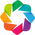

:Layout
   .Overlay.Equity   :Overlay
      .Curve.Equity              :Curve   [x]   (Cumulative Return (%))
      .Curve.Equity_w_over_o_fee :Curve   [x]   (Cumulative Return (%))
      .Curve.Price               :Curve   [x]   (Price)
   .Overlay.Position :Overlay
      .Curve.Position :Curve   [x]   (Position (Qty))
      .Curve.Price    :Curve   [x]   (Price)

In [49]:
stats.plot()